# Analyse de la population mondiale

## Introduction

Pour ce sujet, j'ai choisie de m'intéresser à des données concernant l'évolution (1960-2023) de différents indicateurs socio-économiques et de santé. Pour cela j'ai choisie de me baser sur les données de la Banque mondiale: https://databank.worldbank.org/source/world-development-indicators. A l'aide de cette page web, j'ai pu récupérer des données complexes, d'origine diverses (Eurostats, ONU, OCDE, etc.).
J'ai choisie d'extraire entre 1960 et 2023 les données de la population mondiale pour tous les pays, ainsi que quelques indicateurs économiques, sociaux et de santé.
Ces données extraites sont parfois incomplètes, comportent un format peu habituel que nous allons devoir reformater pour les rendre plus facilement manipulable.
Dans un premier temps, nous allons reformater les données puis réaliser quelques analyses descriptives. Ensuite, nous allons gérer les valeurs manquantes et nous traiterons les données afin de les rendre exploitable par différents modèles prédictifs.

La problématique principale de ce projet est de prédire la population mondiale à l'aide des données disponibles. Pour cela, nous utiliserons différents modèles de machine learning, ainsi que des modèles de séries temporelles ou de régression.

## 1 Premier import/reformatage des données
Dans un premier temps nous allons importer les données et les reformater pour les rendre plus facilement manipulable. Les colonnes présentant les années : 1960 [YR1960] => YR1960, 1961 [YR1961] => YR1961, ... , 2023 [YR2023] => YR2023, vont être replacées par une colonne "Year" avec les valeurs 1960, 1961, ... , 2023. Egalement les lignes de Series Name présentant les indicateurs socio-économiques vont être replacé en colonne afin de pouvoir les traiter plus aisément.
Cette première étape permet d'obtenir un dataframe "classique": au format tabulaire avec des colonnes uniques pour chaque paramètre.

Par la suite, nous allons observer ces données brutes puis nous utiliserons des méthodes pour gérer les valeurs manquantes et nous traiterons les données afin de les rendre exploitable par différents modèles prédictifs.


In [1]:
import pandas as pd
from IPython.display import display
import warnings
import random
warnings.filterwarnings("ignore")
# InteractiveShell.ast_node_interactivity = "all"
random.seed(7)

data = pd.read_csv("data/pop_1960_2023.csv")


data = data.drop(["Series Code"], axis=1)

# utiliser missMDA pour gérer les Nan


rename_dict = {}
# Renommer colonnes : 1960 [YR1960] => YR1960
for col in data.columns:
    if col[0].isdigit():
        rename_dict[col] = col[:4]
data = data.rename(columns=rename_dict)
        
# remettre données année en ligne et variable en colonne



data = pd.melt(data, id_vars=list(data.columns[0:3]), value_vars = list(data.columns[3:]))
data = data.rename(columns={"variable":"Year"})
print(data.columns)

# data_unique = data.drop_duplicates(subset=["Country Name", "Country Code", "Year", "Series Name"])


# Pivot pour que les valeurs de "Series Name" deviennent des colonnes
data_pivot = data.pivot_table(
    index=["Country Name", "Country Code", "Year"],
    columns="Series Name",
    values="value",
    aggfunc='first'  
)

# a vérifier la logique 

data_pivot = data_pivot.reset_index()
data = data_pivot
display(data_pivot[data_pivot["Country Name"]=="Afghanistan"])


data.to_csv("data/data_final.csv", index=False)
len(data["Country Name"].unique())

# bien penser à séparer les agrégats des données de base (pays)
# data_pays = 
# data_continent = 


Index(['Country Name', 'Country Code', 'Series Name', 'Year', 'value'], dtype='object')


Series Name Country Name Country Code  Year  \
0            Afghanistan          AFG  1960   
1            Afghanistan          AFG  1961   
2            Afghanistan          AFG  1962   
3            Afghanistan          AFG  1963   
4            Afghanistan          AFG  1964   
..                   ...          ...   ...   
59           Afghanistan          AFG  2019   
60           Afghanistan          AFG  2020   
61           Afghanistan          AFG  2021   
62           Afghanistan          AFG  2022   
63           Afghanistan          AFG  2023   

Series Name Access to electricity (% of population)  \
0                                                ..   
1                                                ..   
2                                                ..   
3                                                ..   
4                                                ..   
..                                              ...   
59                                             97.7   
60                                             97.7   
61                                             97.7   
62                                             85.3   
63                                               ..   

Series Name Adjusted net national income (current US$)  \
0                                                   ..   
1                                                   ..   
2                                                   ..   
3                                                   ..   
4                                                   ..   
..                                                 ...   
59                                    17731939790.9716   
60                                     18585819842.831   
61                                     13621070038.579   
62                                                  ..   
63                                                  ..   

Series Name Birth rate, crude (per 1,000 people)  \
0                                          50.34   
1                                         50.443   
2                                          50.57   
3                                         50.703   
4                                         50.831   
..                                           ...   
59                                        36.466   
60                                        36.051   
61                                        35.842   
62                                        35.143   
63                                            ..   

Series Name Death rate, crude (per 1,000 people)  \
0                                         31.921   
1                                         31.349   
2                                         30.845   
3                                         30.359   
4                                         29.867   
..                                           ...   
59                                         6.791   
60                                         7.113   
61                                         7.344   
62                                         6.906   
63                                            ..   

Series Name Electric power consumption (kWh per capita)  \
0                                                    ..   
1                                                    ..   
2                                                    ..   
3                                                    ..   
4                                                    ..   
..                                                  ...   
59                                                   ..   
60                                                   ..   
61                                                   ..   
62                                                   ..   
63                                                   ..   

Series Name Exports of goods and services (% of GDP)  \
0                                                 ..   
1     

218

Dans ce premier bloc de code, nous avons importé les données de la Banque mondiale et nous les avons reformater pour les rendre plus facilement manipulable. Ensuite, nous affichons un sous ensemble des données pour vérifier que les données ont été correctement importées et reformater, les .. correspondent à des valeurs manquantes qui seront gérées par la suite.


## 2 Traitement des données de population mondiale

### Objectif
L'objectif est de nettoyer et d'enrichir les données de la Banque mondiale concernant les indicateurs de développement mondial. Plus précisément, nous allons :

1. Filtrer le dataset pour ne garder que les 195 pays reconnus
2. Ajouter une colonne "Continent" pour permettre des analyses par région géographique
3. Séparer les agrégats (comme "World") dans un dataframe distinct

### Méthodologie
1. **Nettoyage des données** : 
   - Normalisation des noms de pays pour correspondre à ceux du dataset original
   - Gestion des valeurs manquantes (représentées par "..")
   
2. **Enrichissement** :
   - Création d'un dictionnaire de correspondance pays/continent
   - Ajout de la colonne "Continent" basée sur ce dictionnaire
   
3. **Séparation des données** :
   - Création d'un dataframe `data_countries` contenant uniquement les pays
   - Création d'un dataframe `data_world` pour les données agrégées
  
Les traitements sont réalisés dans le fichier "continent.py", afin de ne pas surcharger le notebook principal.
### Structure des données résultantes
- **data_countries** : dataframe contenant les 195 pays avec des informations comme la population, les indicateurs économiques, sociaux et de santé, ainsi que le continent de chaque pays
- **data_world** : dataframe contenant les données agrégées au niveau mondial

Cette structure permettra de faciliter les analyses par pays et par continent, tout en gardant accès aux données globales si nécessaire.

In [2]:
data = pd.read_csv("data/data_final.csv")

len(data["Country Name"].unique())

# on va se ramener à 195 pays selon la liste des pays reconnus

218

In [3]:

import importlib
import continent
importlib.reload(continent)
from continent import process_countries_data

# Traitement des données et récupération des résultats

data_countries, data_world = process_countries_data() # fonction d'exctraction/nettoyage des pays (195 reconnus) et de définition des continents


len(data_countries["Country Name"])

# on a donc 194 * (2023-1960) observations soit 12416 lignes et une dizaine de colonnes indicatrice.


Nombre de pays uniques dans data_countries : 194
Pays manquants : {'Holy See', 'Taiwan, Province of China'}


12416

In [4]:
data = pd.read_csv("data/data_countries.csv")
data_world = pd.read_csv("data/data_world.csv")

print(data.columns)


Index(['Country Name', 'Country Code', 'Year',
       'Access to electricity (% of population)',
       'Adjusted net national income (current US$)',
       'Birth rate, crude (per 1,000 people)',
       'Death rate, crude (per 1,000 people)',
       'Electric power consumption (kWh per capita)',
       'Exports of goods and services (% of GDP)',
       'GDP per capita (current US$)',
       'Life expectancy at birth, total (years)',
       'Population growth (annual %)', 'Population, total',
       'Suicide mortality rate (per 100,000 population)',
       'Standard Country Name', 'Continent'],
      dtype='object')


## 3 Analyse descriptive

### Objectif :
- Décrire les tendances au regard des variables dont on dispose. 
- Etudier les corrélations entre les variables.
- Détecter les valeurs manquantes.
- Réaliser un dashboard interactif, simple et efficace pour explorer le jeu de données.


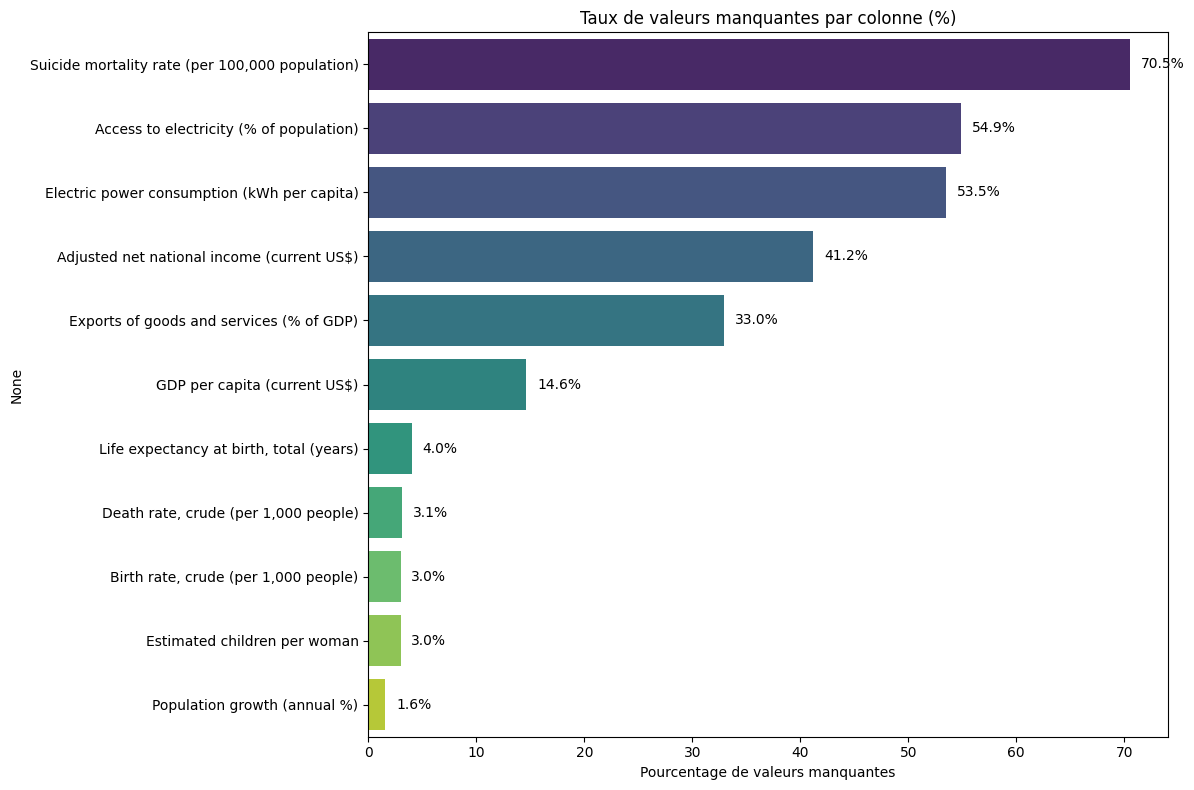

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd

# Remplacer les ".." par des NaN
data_clean = data.copy()
data_clean = data_clean.replace("..", np.nan)

# Convertir les colonnes numériques en float
numeric_cols = [
    'Access to electricity (% of population)',
    'Adjusted net national income (current US$)',
    'Birth rate, crude (per 1,000 people)',
    'Death rate, crude (per 1,000 people)',
    'Electric power consumption (kWh per capita)',
    'Exports of goods and services (% of GDP)',
    'GDP per capita (current US$)',
    'Life expectancy at birth, total (years)',
    'Population growth (annual %)',
    'Population, total',
    'Suicide mortality rate (per 100,000 population)'
]

for col in numeric_cols:
    data_clean[col] = pd.to_numeric(data_clean[col], errors='coerce')

# Ajouter l'estimation du nombre d'enfants par femme: (CBR/1000)*40*4
data_clean['Estimated children per woman'] = (data_clean['Birth rate, crude (per 1,000 people)'] / 1000) * 40 * 4

# Définir une palette de couleurs fixe pour les continents et le monde
color_mapping = {
    "Africa": "#FF9500",      # Orange
    "Asia": "#FF5A5F",        # Rouge
    "Europe": "#007A87",      # Bleu-vert
    "North America": "#8CE071", # Vert
    "South America": "#7B0051", # Violet
    "Oceania": "#00D1C1",     # Turquoise
    "Monde": "#FFCD00"        # Jaune doré
}

# Le reste du code pour les valeurs manquantes
missing_values = data_clean.isna().sum()
missing_rate = (missing_values / len(data_clean)) * 100

missing_df = pd.DataFrame({
    'Nombre de valeurs manquantes': missing_values,
    'Taux de valeurs manquantes (%)': missing_rate
})

# print("Taux de valeurs manquantes par colonne:")
# display(missing_df.sort_values('Taux de valeurs manquantes (%)', ascending=False))

# 1. Visualisation des taux de valeurs manquantes
missing_df = missing_df[missing_df['Nombre de valeurs manquantes'] > 0].sort_values('Taux de valeurs manquantes (%)', ascending=False)

plt.figure(figsize=(12, 8))
ax = sns.barplot(x=missing_df['Taux de valeurs manquantes (%)'].values, 
                y=missing_df.index, 
                palette='viridis')

for i, v in enumerate(missing_df['Taux de valeurs manquantes (%)']):
    ax.text(v + 1, i, f"{v:.1f}%", va='center')

plt.title('Taux de valeurs manquantes par colonne (%)')
plt.xlabel('Pourcentage de valeurs manquantes')
plt.tight_layout()
plt.show()



Ici, on peut voir que certaines colonnes comportent une majorité de valeurs inconnues, tel que celle sur le suicide, et les 2 colonnes sur le thème de l'électricité. Nous les mettrons donc probablement de coté par la suite afin d'avoir des données, même en partie interpoler ou estimer qui soit un minimum proche de la réalité.

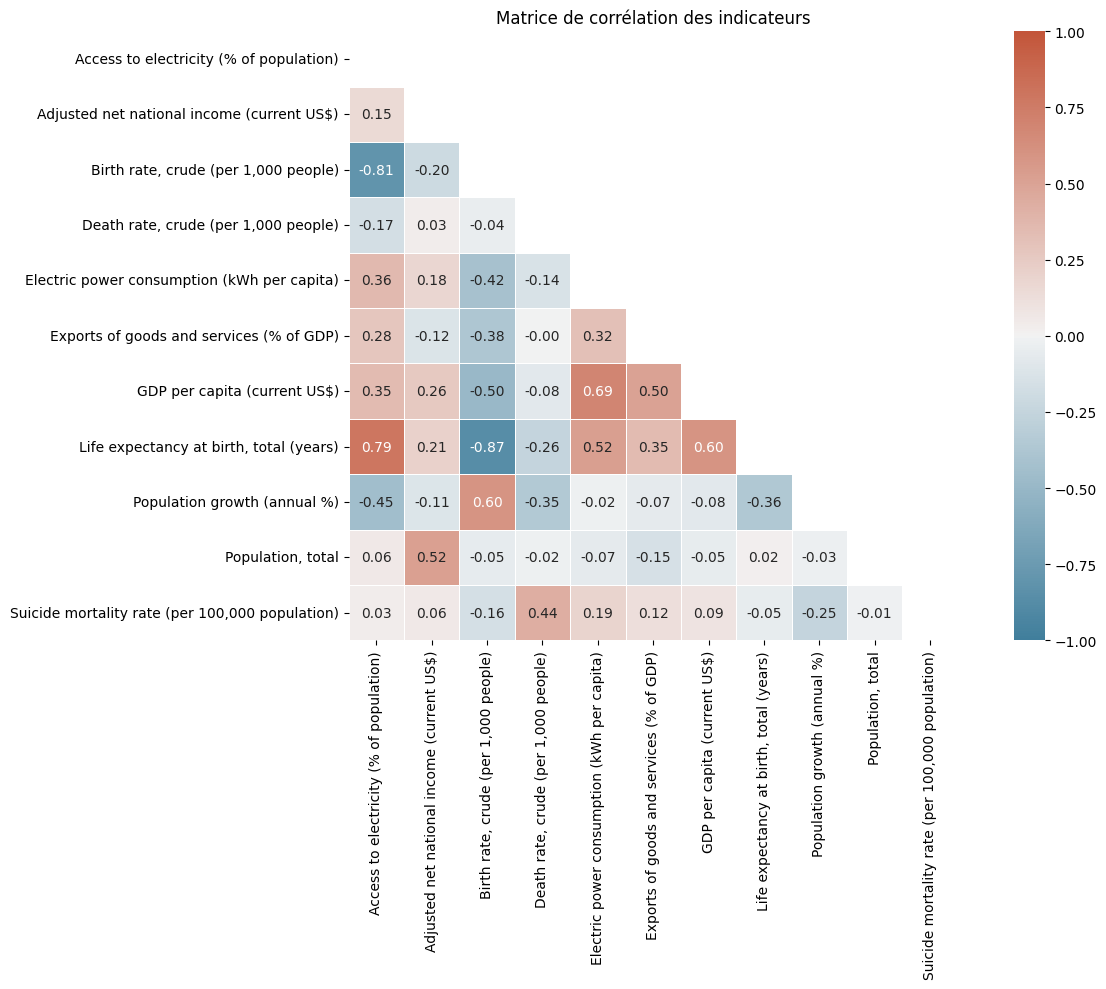

In [6]:
# Matrice de corrélation
recent_data = data_clean[data_clean['Year'] >= 2010].copy()
corr_matrix = recent_data[numeric_cols].corr()

plt.figure(figsize=(14, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, annot=True, fmt=".2f")
plt.title('Matrice de corrélation des indicateurs')
plt.tight_layout()
plt.show()


Cette matrice de corrélation nous montre des liens forts entre certaines variable telle que : l'accès à l'électricité et l'espérance de vie, l'espérance de vie et le taux d'enfants (brut /1000 individus), et entre la consommation électrique et le PIB/hab. Je n'ai pas relevé tous les liens car certains sont tout simplement évident telle que celui entre taux de croissance (habitant) et le taux de naissance. 

La consommation électrique par habitant est très corrélée au PIB/hab, ce qui peut aussi s'expliquer assez simplement en considérant l'économie comme de l'énergie transformée, ainsi une consommation d'énergie élevée serait liée directement à un niveau d'utilisation technologique élevé et donc évidemment à un niveau de revenue/PIB élevé. 

A noter, la population totale semble moyennement corrélé au revenue national net.

Nous allons par la suite, revenir sur certaines de ces liens de corrélation par la suite de manière plus approfondie.




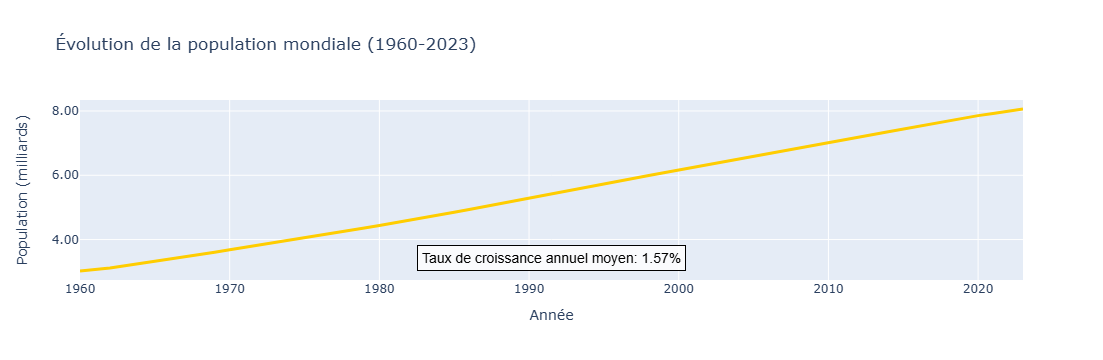

In [7]:

# Fonction pour obtenir l'année la plus récente avec des données disponibles
def get_latest_year_with_data(df, columns, start_year=2023, min_countries=10):
    year = start_year
    while year >= 2010:
        year_data = df[df['Year'] == year].dropna(subset=columns)
        if len(year_data) >= min_countries:
            return year
        year -= 1
    return 2020

# 2. Graphique de l'évolution de la population mondiale et par continent
# 2.1 Graphique pour la population mondiale seule
world_pop = data_world[['Year', 'Population, total']].replace('..', np.nan)
world_pop['Population, total'] = pd.to_numeric(world_pop['Population, total'], errors='coerce')
world_pop = world_pop.dropna()

fig_world = go.Figure()
fig_world.add_trace(go.Scatter(
    x=world_pop['Year'],
    y=world_pop['Population, total']/1e9,
    mode='lines',
    name='Population mondiale',
    line=dict(color=color_mapping['Monde'], width=3)
))

fig_world.update_layout(
    title='Évolution de la population mondiale (1960-2023)',
    xaxis=dict(
        title='Année',
        tickmode='linear', 
        tick0=1960, 
        dtick=10
    ),
    yaxis=dict(
        title='Population (milliards)',
        tickformat='.2f'
    ),
    hovermode="x"
)

# Ajouter une annotation pour le taux de croissance global
first_year = world_pop['Year'].min()
last_year = world_pop['Year'].max()
first_pop = world_pop[world_pop['Year'] == first_year]['Population, total'].values[0]
last_pop = world_pop[world_pop['Year'] == last_year]['Population, total'].values[0]
growth_rate = (last_pop / first_pop) ** (1 / (last_year - first_year)) - 1

fig_world.add_annotation(
    x=0.5,
    y=0.05,
    xref="paper",
    yref="paper",
    text=f"Taux de croissance annuel moyen: {growth_rate*100:.2f}%",
    showarrow=False,
    font=dict(
        family="Arial",
        size=14,
        color="black"
    ),
    align="center",
    bgcolor="rgba(255, 255, 255, 0.8)",
    bordercolor="black",
    borderwidth=1,
    borderpad=4
)

fig_world.show()



Ici, nous avons simplement l'évolution de la population mondiale qui à plus que doublé en 60 ans passant de 3 milliards à plus de 8 milliards en 2023. Cette croissance (sur cette période) est ici assez linéaire avec un taux de croissance qui varie assez peu avec une moyenne à 1,57% par an.

In [8]:
# 2.2 Graphique en grille pour l'évolution des populations par continent
pop_by_continent = data_clean.groupby(['Continent', 'Year'])['Population, total'].sum().reset_index()
pop_by_continent = pop_by_continent.dropna()

# S'assurer que tous les continents sont présents
all_continents = ['Africa', 'Asia', 'Europe', 'North America', 'Oceania', 'South America']
present_continents = pop_by_continent['Continent'].unique()
missing_continents = [c for c in all_continents if c not in present_continents]

if missing_continents:
    print(f"Continents manquants dans les données: {missing_continents}")
    for continent in missing_continents:
        dummy_data = pd.DataFrame({
            'Continent': [continent] * len(world_pop),
            'Year': world_pop['Year'],
            'Population, total': [0] * len(world_pop)
        })
        pop_by_continent = pd.concat([pop_by_continent, dummy_data])

# Traductions pour les titres de continents
continent_translations = {
    'Africa': 'Afrique',
    'Asia': 'Asie',
    'Europe': 'Europe',
    'North America': 'Amérique du Nord',
    'South America': 'Amérique du Sud',
    'Oceania': 'Océanie'
}

# Créer une grille de 2x3 pour les 6 continents
subplot_titles = [continent_translations.get(continent, continent) for continent in all_continents]
fig_continents = make_subplots(
    rows=2, 
    cols=3, 
    subplot_titles=subplot_titles,
    shared_xaxes=True,
    vertical_spacing=0.1
)

# Ajouter les traces pour chaque continent avec son échelle appropriée
for i, continent in enumerate(all_continents):
    row = i // 3 + 1
    col = i % 3 + 1
    
    continent_data = pop_by_continent[pop_by_continent['Continent'] == continent]
    
    if not continent_data.empty:
        # Calculer les valeurs en milliards ou millions selon la taille de la population
        max_pop = continent_data['Population, total'].max()
        if max_pop > 1e9:
            y_values = continent_data['Population, total'] / 1e9
            y_unit = "milliards"
        else:
            y_values = continent_data['Population, total'] / 1e6
            y_unit = "millions"
        
        # Ajouter la trace pour ce continent
        fig_continents.add_trace(
            go.Scatter(
                x=continent_data['Year'],
                y=y_values,
                mode='lines',
                name=continent_translations.get(continent, continent),
                line=dict(color=color_mapping[continent], width=2)
            ),
            row=row, 
            col=col
        )
        
        # Calculer et afficher le taux de croissance comme texte sur le graphique
        if len(continent_data) > 1:
            first_year_data = continent_data.sort_values('Year').iloc[0]
            last_year_data = continent_data.sort_values('Year').iloc[-1]
            years_diff = last_year_data['Year'] - first_year_data['Year']
            
            if years_diff > 0:
                continent_growth = (last_year_data['Population, total'] / first_year_data['Population, total']) ** (1 / years_diff) - 1
                
                # Ajouter le taux comme texte sur le graphique plutôt que comme annotation
                midpoint_year = (first_year_data['Year'] + last_year_data['Year']) / 2
                midpoint_y = y_values.max() * 0.8
                
                fig_continents.add_trace(
                    go.Scatter(
                        x=[midpoint_year],
                        y=[midpoint_y],
                        mode='text',
                        text=[f"Croissance: {continent_growth*100:.2f}%/an"],
                        textfont=dict(
                            size=10,
                            color='black'
                        ),
                        showlegend=False,
                        hoverinfo='none'
                    ),
                    row=row,
                    col=col
                )
                
                # Mise à jour des axes y pour indiquer l'unité
for i, continent in enumerate(all_continents):
    row = i // 3 + 1
    col = i % 3 + 1
    
    continent_data = pop_by_continent[pop_by_continent['Continent'] == continent]
    if not continent_data.empty:
        max_pop = continent_data['Population, total'].max()
        if max_pop > 1e9:
            y_unit = "milliards"
        else:
            y_unit = "millions"
            
        fig_continents.update_yaxes(
            title_text=f"Population ({y_unit})",
            row=row,
            col=col
        )
                
# Mise à jour de la mise en page
fig_continents.update_layout(
    title="Évolution de la population par continent (1960-2023)",
    showlegend=False,
    height=700,
    width=1000
)

# Mise à jour des axes x pour avoir le même format
for i in range(1, 7):
    row = (i-1) // 3 + 1
    col = (i-1) % 3 + 1
    
    fig_continents.update_xaxes(
        title_text="Année" if row == 2 else None,
        tickmode='linear',
        tick0=1960,
        dtick=20,
        row=row,
        col=col
    )

fig_continents.show()


Cette ensemble de graphique permet de préciser la vue précédente avec une vision moins macro, en se plaçant à l'échelle du continent, nous pouvons ainsi voir que la tendance globale de croissance qui est certes présentes dans chaque partie du monde également, se fait d'une manière plus au moins rapide et durable. Sans trop de surprise, nous voyons que l'Afrique suit une tendance plutôt exponentielle avec une population qui a plus que quadruplé de 1960 à 2023, dépassant la barre des 1.4 milliards en 2023. Concernant l'Asie, l'Amérique (Nord et Sud) et l'Océanie; la courbe est  plus proche d'une droite linéaire et le taux de croissance moyen va de 1.29 à 1.71%. Bien entendu, l'Asie reste de très loin le continent le plus peuplé avec près de 5 milliards d'habitant à l'heure actuelle. Et pour finir, l'Europe dont la population a très peu augmentée (486 millions à 596 millions d'habitants) semble plutôt être sur une tendance logarithmique sur la période étudié avec seulement 0.33% de taux de croissance en moyenne.

In [9]:
# Pour les autres graphiques utilisant des continents, on va aussi fixer les couleurs

# 3. Carte choroplèthe - PIB par habitant 
gdp_year = get_latest_year_with_data(data_clean, ['GDP per capita (current US$)'])
gdp_latest = data_clean[data_clean['Year'] == gdp_year].copy()
gdp_latest = gdp_latest.dropna(subset=['GDP per capita (current US$)'])

fig = px.choropleth(gdp_latest, 
                    locations="Country Code", 
                    color="GDP per capita (current US$)",
                    hover_name="Country Name", 
                    color_continuous_scale=px.colors.sequential.Viridis,
                    title=f"PIB par habitant par pays ({gdp_year})")
fig.update_layout(title_text=f"PIB par habitant par pays ({gdp_year})")
fig.show()



Cette carte, permet de visualiser le PIB par habitant, qui est l'un des indicateurs les plus courants de l'états de développement économique d'un pays, il aurait pu être intéressant de le croiser avec d'autres paramètres tel que l'IDH ou l'indicateur de Gini (inégalité), ou d'autres liés à l'éducation ou au bonheur...

Cette carte nous permet de distinguer aisément les pays les plus développés avec des PIB (produit intérieur brut)/habitant plus élevé qui apparaissent plus clair. Pour tous ces cartes, j'ai choisies un plotly pour permettre une interactivité facile et intuitive.

Les pays en blanc, sont sans informations, ici le Venezuela et le Groenland.



In [10]:
# 4. Carte choroplèthe - Croissance de la population
growth_year = get_latest_year_with_data(data_clean, ['Population growth (annual %)'])
growth_latest = data_clean[data_clean['Year'] == growth_year].copy()
growth_latest = growth_latest.dropna(subset=['Population growth (annual %)'])

fig = px.choropleth(growth_latest, 
                    locations="Country Code", 
                    color="Population growth (annual %)",
                    hover_name="Country Name", 
                    color_continuous_scale=px.colors.diverging.RdBu,
                    title=f"Croissance annuelle de la population par pays ({growth_year})")
fig.update_layout(title_text=f"Croissance annuelle de la population par pays ({growth_year})")
fig.show()



Cette carte montre la croissance de population de 2023, en taux par rapport à 2022. La quasi-totalité des pays développés ou semi-développés sont à des taux de croissance assez bas, notamment en Europe. Bien entendue, l'Ukraine ressort en négatif au vue du contexte géopolitique actuel.

Certains pays tel que le Japon, la Chine, et l'Italie (et d'autres) sont en léger négatif et donc au début d'une potentielle décroissance démographique.

In [11]:
# 5. Carte choroplèthe - Nombre estimé d'enfants par femme
fertility_year = get_latest_year_with_data(data_clean, ['Birth rate, crude (per 1,000 people)'])
fertility_latest = data_clean[data_clean['Year'] == fertility_year].copy()
fertility_latest = fertility_latest.dropna(subset=['Birth rate, crude (per 1,000 people)'])

fig = px.choropleth(fertility_latest, 
                    locations="Country Code", 
                    color="Estimated children per woman",
                    hover_name="Country Name",
                    hover_data=["Birth rate, crude (per 1,000 people)"],
                    color_continuous_scale=px.colors.sequential.Plasma,
                    title=f"Nombre estimé d'enfants par femme ({fertility_year}) - Estimation basée sur: (CBR/1000)*40*4")
fig.update_layout(title_text=f"Nombre estimé d'enfants par femme ({fertility_year}) - Estimation basée sur: (CBR/1000)*40*4")
fig.show()



Pour en finir avec les cartes, j'ai trouvé que celle-ci complété parfaitement la précédente, avec l'un des facteurs majeurs de la croissance de la population, qui est le taux de natalité. Elle met en avant la forte natalité Africaine, particulièrement marqué en Centrafrique, mais aussi en Afrique subsaharienne. Si la tendance ce poursuit, l'Afrique sera probablement la première région du monde en terme de population d'ici 2050. 
N'ayant pas la donnée du nombre d'enfant par femme, je l'ai estimé avec l'hypothèse que 25% des femmes était entre 15 et 55 ans, considérant cette période comme équivalente à celle de fertilité, ce qui donne la formule donnée en titre. 


In [12]:
# 6. Top 10 pays les plus peuplés
pop_year = get_latest_year_with_data(data_clean, ['Population, total'], min_countries=100)
pop_latest = data_clean[data_clean['Year'] == pop_year].copy()
pop_latest = pop_latest.dropna(subset=['Population, total'])
pop_latest = pop_latest.sort_values('Population, total', ascending=False).head(10)

custom_colors = px.colors.qualitative.Prism[:10]

fig = px.bar(pop_latest, 
             x='Country Name', 
             y='Population, total',
             title=f'Top 10 pays les plus peuplés ({pop_year})',
             labels={'Population, total': 'Population', 'Country Name': 'Pays'},
             color='Country Name',
             color_discrete_sequence=custom_colors)

fig.update_traces(
    texttemplate='%{y:,.0f}', 
    textposition='inside',
    hovertemplate='<b>%{x}</b><br>Population: %{y:,.0f}'
)

fig.update_layout(
    xaxis={'categoryorder': 'total descending', 'title': 'Pays'},
    xaxis_tickangle=-45,
    yaxis=dict(title='Population'),
    uniformtext_minsize=8,
    uniformtext_mode='hide',
    plot_bgcolor='rgb(248,248,248)',
    title_text=f'Top 10 des pays les plus peuplés ({pop_year})'
)

world_population = world_pop[world_pop['Year'] == pop_year]['Population, total'].values[0] if pop_year in world_pop['Year'].values else world_pop['Population, total'].iloc[-1]


fig.show()



Ici, sans surprise les pays les plus peuplés au monde sont de très loin l'Inde et la Chine qui comptabilisent plus d'1 milliards de personnes, suivi par les Etats-Unis à 334 millions. Ce classement pourrait être amener à fortement évolué d'ici une ou deux dizaines d'années, en supposant que la croissance Africaine se maintiennent au même rythme, par exemple le Nigeria pourrait devenir rapidement 3ème pays le plus peuplé au monde, si l'on reprend les taux de la carte précédente. Le Pakistan devrait aussi dépasser l'Indonésie et les Etats-Unis, dans quelques années. D'autres pays Africains pourrait aussi apparaître dans ce classement prochainement: Ethiopie, RDC...

In [13]:
# 7. Scatter plots avec couleurs de continents fixes
# Fonction pour créer un scatter plot avec des couleurs de continents fixes
def create_continent_scatter(data_df, x_col, y_col, size_col='Population, total', 
                             title="", x_label="", y_label="", use_log_x=True, year=None):
    
    fig = go.Figure()
    
    # Ajouter chaque continent séparément avec une couleur fixe
    for continent in all_continents:
        continent_data = data_df[data_df['Continent'] == continent]
        if not continent_data.empty:
            fig.add_trace(go.Scatter(
                x=continent_data[x_col],
                y=continent_data[y_col],
                mode='markers',
                name=continent,
                marker=dict(
                    color=color_mapping[continent],
                    size=continent_data[size_col]/1e6 if size_col else 10,  # Taille proportionnelle à la population
                    sizemode='area',
                    sizeref=0.1,
                    sizemin=4
                ),
                text=continent_data['Country Name'],
                hovertemplate="<b>%{text}</b><br>" +
                              f"{x_label}: %{{x}}<br>" +
                              f"{y_label}: %{{y}}<br>" +
                              "Population: %{marker.size:.1f}M<br>" +
                              "<extra></extra>"
            ))
    
    # Ajouter une ligne de tendance (régression)
    if len(data_df) > 2:
        try:
            from scipy import stats
            slope, intercept, r_value, p_value, std_err = stats.linregress(
                data_df[x_col].astype(float), 
                data_df[y_col].astype(float)
            )
            
            x_range = data_df[x_col].astype(float)
            x_min, x_max = min(x_range), max(x_range)
            x_trend = [x_min, x_max]
            y_trend = [slope * x + intercept for x in x_trend]
            
            fig.add_trace(go.Scatter(
                x=x_trend, 
                y=y_trend,
                mode='lines',
                name=f'Tendance (r²={r_value**2:.2f})',
                line=dict(color='grey', width=1, dash='solid')
            ))
        except Exception as e:
            print(f"Erreur lors du calcul de la tendance: {e}")
    
    # Mise en page
    fig.update_layout(
        title=title + (f" ({year})" if year else ""),
        xaxis=dict(
            title=x_label,
            type='log' if use_log_x else 'linear'
        ),
        yaxis=dict(title=y_label),
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
        )
    )
    
    return fig

# 7. Espérance de vie vs PIB par habitant
life_gdp_year = get_latest_year_with_data(data_clean, ['Life expectancy at birth, total (years)', 'GDP per capita (current US$)'])
scatter_latest = data_clean[data_clean['Year'] == life_gdp_year].copy()
scatter_latest = scatter_latest.dropna(subset=['Life expectancy at birth, total (years)', 'GDP per capita (current US$)'])

fig = create_continent_scatter(
    scatter_latest,
    'GDP per capita (current US$)',
    'Life expectancy at birth, total (years)',
    title="Espérance de vie vs PIB par habitant",
    x_label="PIB par habitant (USD)",
    y_label="Espérance de vie (années)",
    use_log_x=True,
    year=life_gdp_year
)
fig.show()

# 8. Taux de natalité vs Espérance de vie
birth_life_year = get_latest_year_with_data(data_clean, ['Birth rate, crude (per 1,000 people)', 'Life expectancy at birth, total (years)'])
birth_life_latest = data_clean[data_clean['Year'] == birth_life_year].dropna(subset=['Birth rate, crude (per 1,000 people)', 'Life expectancy at birth, total (years)'])

fig = create_continent_scatter(
    birth_life_latest,
    'Birth rate, crude (per 1,000 people)',
    'Life expectancy at birth, total (years)',
    title="Corrélation entre taux de natalité et espérance de vie",
    x_label="Taux de natalité (pour 1000 habitants)",
    y_label="Espérance de vie (années)",
    use_log_x=False,
    year=birth_life_year
)
fig.show()



Sur ces 2 graphiques, chaque point est un pays, dont la couleur est le continent d'appartenance et la taille est proportionnelle à la population. Sur l'axe verticale nous avons l'espérance de vie et en horizontale nous avons le PIB/hab (1er graphique) puis le taux de natalité (2ème graphique). Ainsi une corrélation linéaire et positive existe entre l'espérance de vie et le PIB/habitant, qu'on pourrais attribuer à des services de santé plus performant et à une meilleur alimentation dans les pays développés (grand PIB/hab). Aussi, une corrélation significative à 0,73 de r2 est observer entre l'espérance de vie et le taux de natalité (brut /1000 habitants). Cette corrélation (négative) pourrait s'expliquer également par une différence d'accès au soin, les bulles oranges étant donc des pays Africains avec une forte natalité et une faible espérance de vie (50-60 ans environ). Contrairement à l'amas de point rose, bleu et vert représentant quand à eux des pays développés avec une faible natalité et au contraire une forte espérance de vie (autour de 80 ans).

In [14]:
# 9. Taux de natalité vs Accès à l'électricité
birth_elec_year = get_latest_year_with_data(data_clean, ['Birth rate, crude (per 1,000 people)', 'Access to electricity (% of population)'])
birth_elec_latest = data_clean[data_clean['Year'] == birth_elec_year].dropna(subset=['Birth rate, crude (per 1,000 people)', 'Access to electricity (% of population)'])

fig = create_continent_scatter(
    birth_elec_latest,
    'Birth rate, crude (per 1,000 people)',
    'Access to electricity (% of population)',
    title="Corrélation entre taux de natalité et accès à l'électricité",
    x_label="Taux de natalité (pour 1000 habitants)",
    y_label="Accès à l'électricité (% de la population)",
    use_log_x=False,
    year=birth_elec_year
)
fig.show()



Ce nuage de point et sa droite de régression montre encore une distinction, une certaine distanciation entre les pays Africains avec un accès à l'électricité faible (inférieur à 90%) et un taux de natalité élevé. Contrairement aux autres pays du monde qui sont presque tous à 100% d'accès à l'électricité et dont la natalité est bien moindres. L'accès à l'électricité étant encore une fois le reflet d'un état développé et dont l'accès à la contraception est plus aisé.

A noter que ces interprétations sont à nuancé, d'autres facteurs socio-culturelles peuvent aussi certainement expliqué ces différences majeurs de natalité, ainsi que des craintes en matière d'écologie ou bien encore un certaines forme d'individualisme et de progressisme auquel les populations en dehors de l'occident ne sont que peu voir pas du tout exposé...

In [15]:
# 10. Consommation électrique vs PIB par habitant (sans échelle logarithmique)
elec_gdp_year = get_latest_year_with_data(data_clean, ['Electric power consumption (kWh per capita)', 'GDP per capita (current US$)'])
elec_gdp_latest = data_clean[data_clean['Year'] == elec_gdp_year].dropna(subset=['Electric power consumption (kWh per capita)', 'GDP per capita (current US$)'])

# Si pas assez de données disponibles pour la dernière année, chercher l'année précédente
if len(elec_gdp_latest) < 10:
    for year in range(elec_gdp_year-1, 2010, -1):
        temp_data = data_clean[data_clean['Year'] == year].dropna(
            subset=['Electric power consumption (kWh per capita)', 'GDP per capita (current US$)'])
        if len(temp_data) >= 10:
            elec_gdp_year = year
            elec_gdp_latest = temp_data
            break

fig = create_continent_scatter(
    elec_gdp_latest,
    'GDP per capita (current US$)',
    'Electric power consumption (kWh per capita)',
    title="Corrélation entre consommation électrique et PIB par habitant",
    x_label="PIB par habitant (USD)",
    y_label="Consommation électrique (kWh par habitant)",
    use_log_x=False,  
    year=elec_gdp_year
)
fig.show()

Ici, j'ai voulu revenir sur la relation entre la dépense énergétique et le PIB, dans le top 5 des pays au plus haut niveau de PIB/hab, nous avons le Luxembourg, la Norvège, le Qatar, la Suisse... 
A ce niveau les pays Européens sont parmis les mieux classé, le pays qui ressort avec une très forte consommation électrique (par habitant) et l'Islande connue pour sa géothermie et ces datacenters notamment.

## Conclusion de l'analyse descriptive

L'analyse descriptive des données de la Banque mondiale montre que la population mondiale a plus que doublé entre 1960 et 2023 pour atteindre plus de 8 milliards, avec un taux de croissance annuel moyen d'environ 1,57 %, tout en révélant d'importantes disparités régionales : l'Afrique connaît une croissance exponentielle qui pourrait en faire la région la plus peuplée d'ici 2050, l'Asie demeure le continent le plus peuplé avec près de 5 milliards d'habitants, et l'Europe affiche une évolution modérée. Par ailleurs, une forte corrélation positive entre le PIB par habitant et l'espérance de vie souligne l'influence du développement économique sur la santé, tandis qu'une corrélation négative entre le taux de natalité et l'espérance de vie, particulièrement marquée en Afrique, met en lumière l'impact de l'accès limité à l'électricité et aux ressources sur ces indicateurs. Des visualisations interactives telles que des cartes choroplèthes et des scatter plots viennent illustrer ces tendances en intégrant des données clés comme le PIB par habitant, la croissance démographique et le nombre estimé d'enfants par femme.


Après avoir observé les données, passons maintenant au nettoyage afin d'obtenir des données propre pour l'utilisation de nos modèles de prédictions de la population. Pour la gestion des Na, tous d'abord nous allons choisir une période temporelle avec un maximum de données tout en enlevant les colonnes principalement composé de vide. Pour les autres Na restant nous allons approximer les valeurs à l'aide du package MissMDA.

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer

# 1. Chargement des données et remplacement des ".." par NaN
data = pd.read_csv("data/data_countries.csv")
data = data.replace("..", np.nan)

# Conversion de certaines colonnes en numérique
numeric_cols = [
    'Adjusted net national income (current US$)',
    'Birth rate, crude (per 1,000 people)',
    'Death rate, crude (per 1,000 people)',
    'Exports of goods and services (% of GDP)',
    'GDP per capita (current US$)',
    'Life expectancy at birth, total (years)',
    'Population growth (annual %)',
    'Population, total'
]
for col in numeric_cols:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# 2. Retirer les colonnes avec plus de 50 % de valeurs manquantes
cols_to_keep = data.columns[data.isnull().mean() < 0.5]
data_clean = data[numeric_cols].copy()


data_numeric = data_clean

data_numeric2 = data_clean.copy()

# Création d'un masque indiquant les positions initiales des valeurs manquantes
mask = data_numeric.isnull()

# 4. Imputation par KNN
imputer = KNNImputer(n_neighbors=5)
data_imputed_numeric = pd.DataFrame(imputer.fit_transform(data_numeric), columns=numeric_cols)

# Remplacer les colonnes numériques du DataFrame nettoyé par les valeurs imputées
data_clean[numeric_cols] = data_imputed_numeric
data[numeric_cols] = data_imputed_numeric
# 5. Sauvegarder le DataFrame final avec toutes les colonnes dans un nouveau fichier CSV
data.to_csv("data/data_countries_imputed.csv", index=False)





In [17]:
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer  # Nécessaire pour activer IterativeImputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor # estimateur : ensemble d'arbre de décision

### peut etre un peu long à éxecuter (la partie imputation)

# Supposons que 'data_numeric2' est votre DataFrame contenant uniquement les colonnes numériques avec des valeurs manquantes
print(data_numeric2.isna().sum())

# Conversion du DataFrame en tableau NumPy
data_array = data_numeric2.to_numpy()

# Création de l'objet IterativeImputer (vous pouvez ajuster les paramètres si besoin)
# iterative_imputer = IterativeImputer(random_state=7, verbose=1, estimator=ExtraTreesRegressor())

# Imputation des valeurs manquantes
# data_imputed_array = iterative_imputer.fit_transform(data_array)

# Reconstruction d'un DataFrame avec les mêmes colonnes que l'original
# data_imputed_iterative = pd.DataFrame(data_imputed_array, columns=data_numeric2.columns)

# Remplacement des colonnes numériques dans le DataFrame global
# data[numeric_cols] = data_imputed_iterative

# Sauvegarde du résultat
# data.to_csv("data/data_countries_imputed_iterative.csv", index=False)


Adjusted net national income (current US$)    5113
Birth rate, crude (per 1,000 people)           371
Death rate, crude (per 1,000 people)           389
Exports of goods and services (% of GDP)      4093
GDP per capita (current US$)                  1815
Life expectancy at birth, total (years)        500
Population growth (annual %)                   196
Population, total                                0
dtype: int64


## 4 Imputation des valeurs manquantes:
### Méthode: 
J'ai testé 2 méthodes pour imputer les valeurs manquantes, l'une basé sur KNN et l'autre sur un ensemble d'arbre de décision (de régression), cette seconde méthode itérative m'a semblé plus juste et c'est donc celle que je garderais pour la suite. Les données sont ensuite stockés dans un csv que l'on peut charger directement par la suite : data\data_countries_imputed_iterative.csv est le chemin relatif de ce fichier. Ensuite nous allons afficher ces valeurs imputés via des histogrammes.

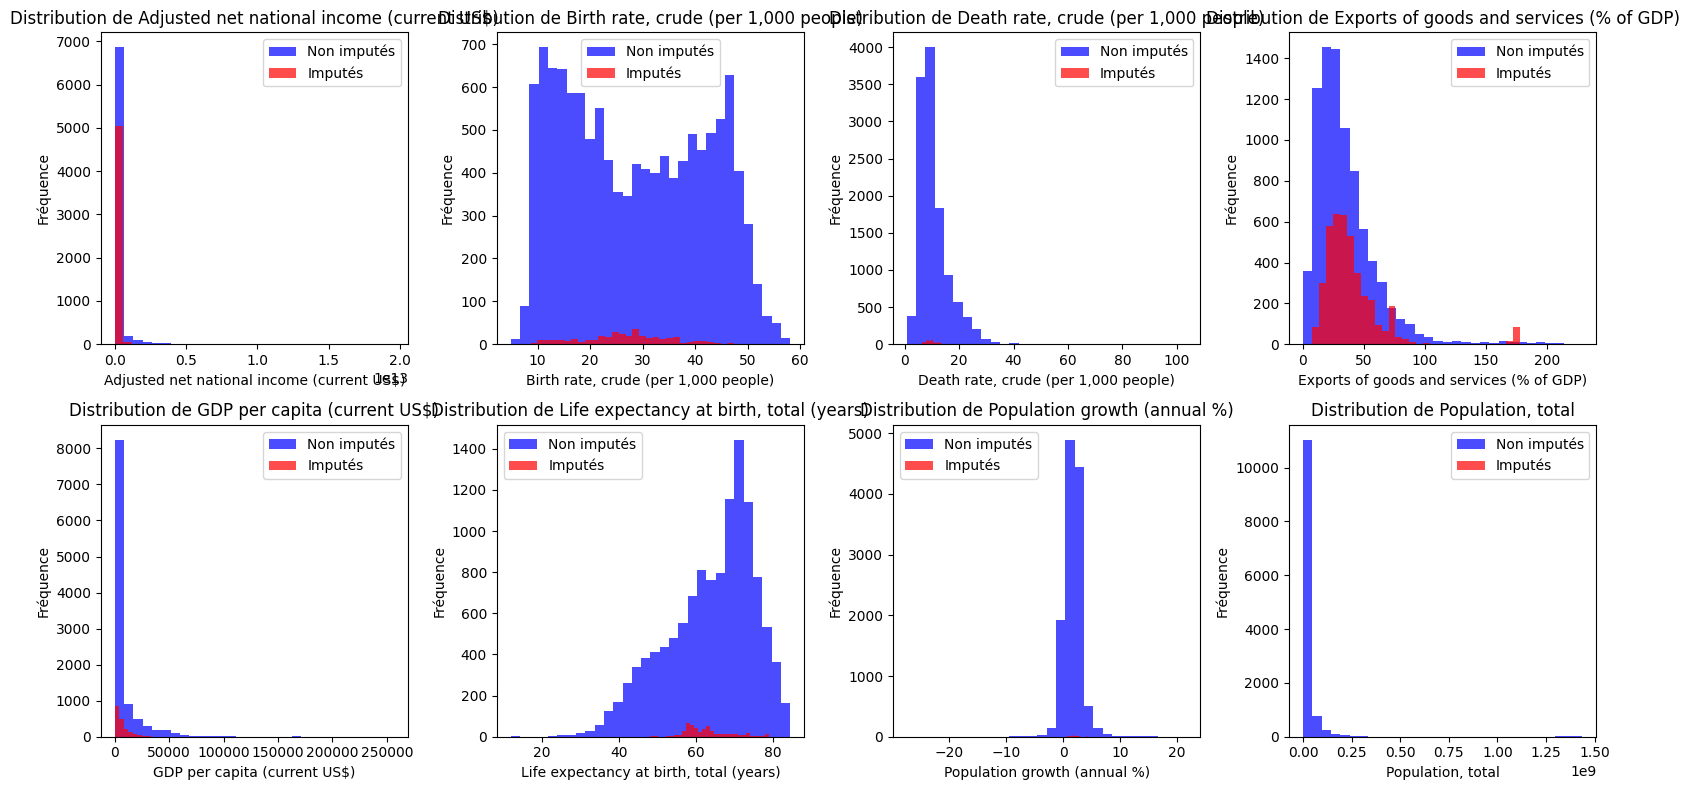

In [18]:
# Visualisation de l'imputation pour une chaque spécifique

import matplotlib.pyplot as plt

# Création d'une figure avec 2 lignes et 4 colonnes
fig, axes = plt.subplots(2, 4, figsize=(16, 8))  # ajustez la taille de la figure au besoin

# Itération sur chaque colonne pour tracer les histogrammes dans le subplot correspondant
for ax, col in zip(axes.flatten(), numeric_cols):
    # Histogramme des valeurs non imputées en bleu
    ax.hist(data[col][~mask[col]], bins=30, color='blue', label='Non imputés', alpha=0.7)
    # Histogramme des valeurs imputées en rouge
    ax.hist(data[col][mask[col]], bins=30, color='red', label='Imputés', alpha=0.7)
    ax.set_xlabel(col)
    ax.set_ylabel("Fréquence")
    ax.set_title(f"Distribution de {col}")
    ax.legend()

plt.tight_layout()
plt.show()






Au niveau des imputations, nous pourrions probablement amélioré cela avec des méthodes itératives (PCA), ou d'autres. Globalement, la distribution des données semblent être assez peu impacté par ce traitement des NaN réalisé. Nous allons ensuite cherché à prédire la population humaine à l'aide de différents modèles.

In [19]:
data = pd.read_csv("data/data_countries_imputed_iterative.csv")
print(data.columns)

predictive_col = ['Country Name','Year',
       'Adjusted net national income (current US$)',
       'Birth rate, crude (per 1,000 people)',
       'Death rate, crude (per 1,000 people)',
       'Exports of goods and services (% of GDP)',
       'GDP per capita (current US$)',
       'Life expectancy at birth, total (years)',
       'Population growth (annual %)',
        'Continent']
data_train = data[data["Year"] < 2016]
data_test = data[data["Year"] >= 2016]
y = "Population, total"
X = data[predictive_col]




Index(['Country Name', 'Country Code', 'Year',
       'Access to electricity (% of population)',
       'Adjusted net national income (current US$)',
       'Birth rate, crude (per 1,000 people)',
       'Death rate, crude (per 1,000 people)',
       'Electric power consumption (kWh per capita)',
       'Exports of goods and services (% of GDP)',
       'GDP per capita (current US$)',
       'Life expectancy at birth, total (years)',
       'Population growth (annual %)', 'Population, total',
       'Suicide mortality rate (per 100,000 population)',
       'Standard Country Name', 'Continent'],
      dtype='object')


## 5 Prédiction de la population
### 5.1 Méthode

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Chargement des données
data = pd.read_csv("data/data_countries_imputed_iterative.csv")
print("Colonnes du DataFrame :", data.columns.tolist())

# Sélection des variables prédictives (attention : certaines colonnes comme "Country Name" et "Continent" ne sont pas numériques)
predictive_col = [
    'Year',
    'Adjusted net national income (current US$)',
    'Birth rate, crude (per 1,000 people)',
    'Death rate, crude (per 1,000 people)',
    'Exports of goods and services (% of GDP)',
    'GDP per capita (current US$)',
    'Life expectancy at birth, total (years)',
    'Population growth (annual %)',
    "Country Name",
    "Continent"
]

# Séparation en jeu d'entraînement (année < 2016) et de test (année >= 2016)
data_train = data[data["Year"] < 2016].copy()
data_test  = data[data["Year"] >= 2016].copy()

# Variable cible (Population, total)
y_col = "Population, total"
y_train = data_train[y_col]
y_test  = data_test[y_col]

# Création des matrices explicatives
X_train = data_train[predictive_col]
X_test  = data_test[predictive_col]

# Sélection des colonnes 
numeric_cols = [
    'Year',
    'Adjusted net national income (current US$)',
    'Birth rate, crude (per 1,000 people)',
    'Death rate, crude (per 1,000 people)',
    'Exports of goods and services (% of GDP)',
    'GDP per capita (current US$)',
    'Life expectancy at birth, total (years)',
    'Population growth (annual %)'
    ]
X_train = X_train[numeric_cols]
X_test  = X_test[numeric_cols]

# Standardisation des variables
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)



Colonnes du DataFrame : ['Country Name', 'Country Code', 'Year', 'Access to electricity (% of population)', 'Adjusted net national income (current US$)', 'Birth rate, crude (per 1,000 people)', 'Death rate, crude (per 1,000 people)', 'Electric power consumption (kWh per capita)', 'Exports of goods and services (% of GDP)', 'GDP per capita (current US$)', 'Life expectancy at birth, total (years)', 'Population growth (annual %)', 'Population, total', 'Suicide mortality rate (per 100,000 population)', 'Standard Country Name', 'Continent']


Ici, nous préparons les données en séparant en 2 ensembles, comme les données correspondent à une série chronologique, nous ne pouvons pas découpé les données d'une manière aléatoire. Donc, j'ai choisie arbitrairement l'année 2016 comme étant la séparation entre mes 2 jeux de données. Ainsi, nous entraînerons les modèles sur les données jusqu'a 2015 puis nous les testerons sur les données de 2016 à 2023, afin de mesurer leur performance via le MSE.

L'ensemble des modèles testées est présent dans le fichier: [prediction.py](./prediction.py), le code peut être long à exécuter (5-10 minutes), pour consulter les résultats directement, vous pouvez voir les images: ![Comparaison des MSE](./mse_comparison.png) et ![Prévision de la population](./population_forecast.png).

In [21]:
# Pour executer le script de prediction.py


# from prediction import compare_models_and_plot
# compare_models_and_plot()


Comme la plupart des modèles donnent des résultats aberrants (principalement du à un fort surapprentissage, une explosion du gradient pour certaines méthodes, etc), je vais par la suite seulement reprendre le modèle ARIMAX, en expliquer le fonctionnement et montré les résultats obtenus plus en détail. Je le comparerai également à un simple modèle logistique souvent utilisé pour prédire l'évolution ou plutôt ici les prévisions de l'évolution de la population humaine. 

## 5 Modèle ARIMAX
### 5.1 Théorie
#### Le Modèle ARIMAX

Le modèle **ARIMAX** est une extension du modèle ARIMA qui intègre des variables exogènes. Ce modèle permet non seulement de capturer la dynamique temporelle d'une série, mais également de tenir compte des influences externes susceptibles d'impacter la variable étudiée.

#### Le Modèle ARIMA de Base

Le modèle ARIMA se compose de trois éléments principaux :

- **AR (AutoRégressive)** : modélise la dépendance entre les observations successives.
- **I (Intégré)** : correspond au nombre de différenciations nécessaires pour rendre la série stationnaire.
- **MA (Moyenne Mobile)** : capture l'effet des chocs ou erreurs passées.

L’équation générale d’un modèle ARIMA s’exprime par :

$$
\phi_p(L)(1-L)^d\,y_t = \theta_q(L)\,\epsilon_t
$$

où :  
- $L$ est l’opérateur de décalage,  
- $y_t$ est la valeur observée à l’instant $t$,  
- $\epsilon_t$ est le terme d’erreur,  
- $\phi_p(L)$ et $\theta_q(L)$ représentent les composantes autorégressive et de moyenne mobile respectivement.

#### Extension vers ARIMAX : Intégration des Variables Exogènes

Le passage de ARIMA à **ARIMAX** se fait par l'ajout de covariables, c'est-à-dire des variables exogènes. Ces variables fournissent un contexte supplémentaire et permettent de mieux expliquer les variations de la série temporelle.

#### Pourquoi utiliser ARIMAX ?

- **Influence des facteurs externes** : Intégrer des covariables telles que le PIB, le taux de natalité ou d'autres indicateurs économiques et démographiques permet de saisir l'impact de facteurs externes sur la série.
- **Amélioration des prévisions** : Le modèle ARIMAX combine la dynamique intrinsèque de la série (capturée par ARIMA) avec les influences externes, ce qui conduit à des prévisions plus précises et pertinentes.

#### L’Équation du Modèle ARIMAX

L’équation générale d’un modèle ARIMAX s’écrit :

$$
\phi_p(L)(1-L)^d\,y_t = \theta_q(L)\,\epsilon_t + \beta\,X_t
$$

où :  
- $X_t$ représente le vecteur des variables exogènes à l’instant $t$,  
- $\beta$ est le vecteur des coefficients associés à ces variables.



### 5.2 Pratique
#### Application à la Prédiction de la Population

Dans le cadre de la prédiction de la population, le modèle ARIMAX peut être utilisé avec des données annuelles et l'intégration de covariables telles que le PIB, le taux de natalité, etc. Cette approche offre plusieurs avantages :

- **Capturer la dynamique temporelle** : grâce aux composantes ARIMA, le modèle saisit l'évolution historique de la population.
- **Intégrer des facteurs contextuels** : les variables exogènes permettent d'ajuster les prévisions en fonction des conditions économiques et démographiques.

En combinant ces deux aspects, le modèle ARIMAX fournit une approche robuste et complète pour la prévision de la population, offrant ainsi des prévisions plus adaptées aux réalités externes et aux changements contextuels.

### 5.3 Comparaison des modèles finaux: ARIMA, ARIMAX et logistique


C:\Users\cedri\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



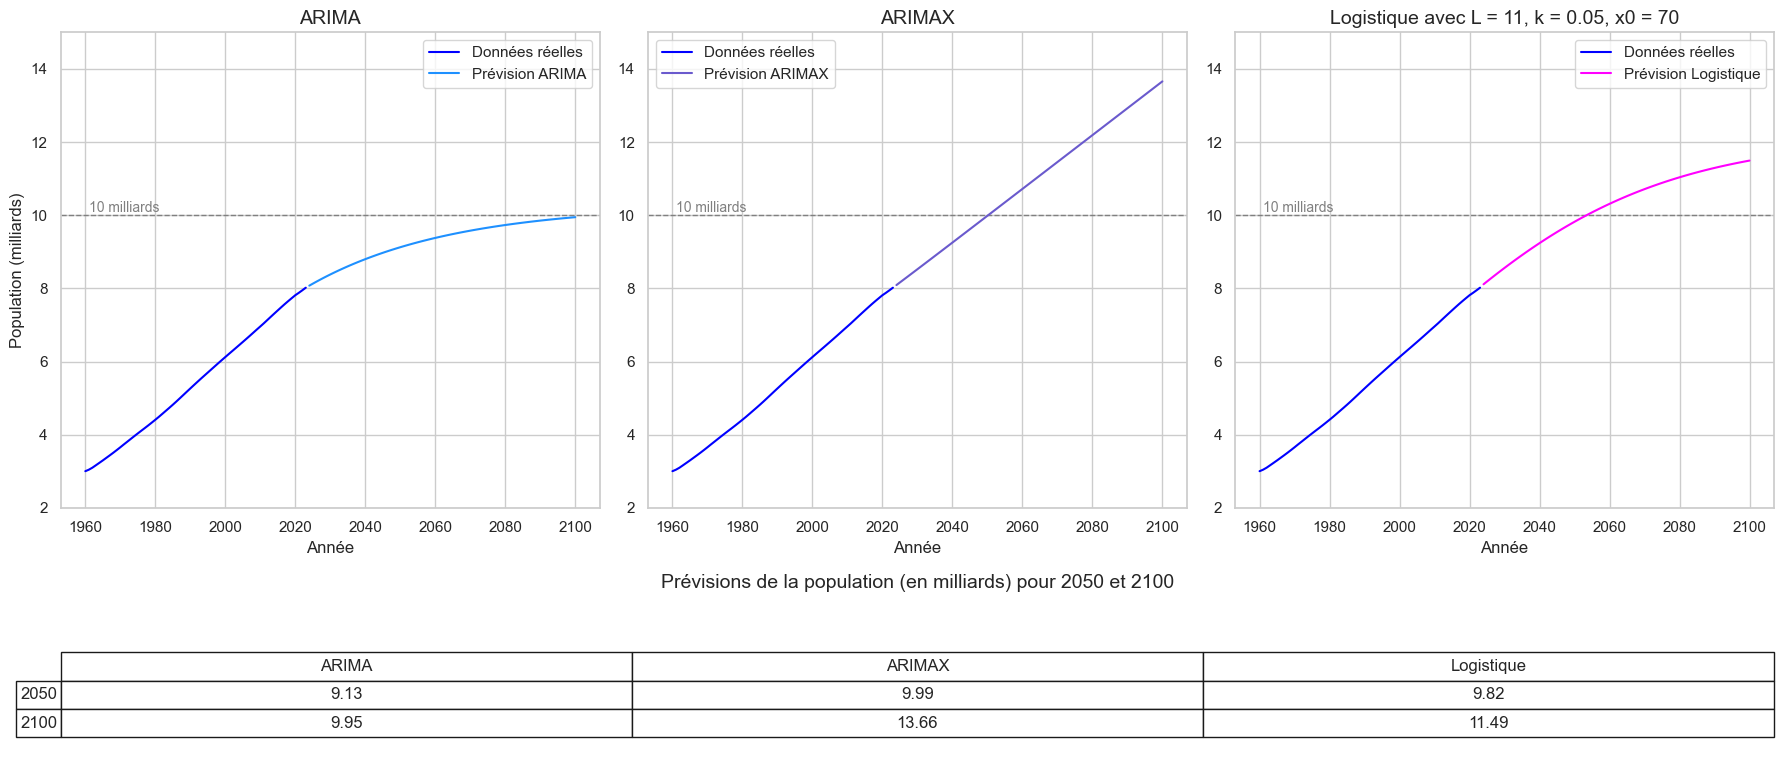

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from scipy.optimize import curve_fit
import matplotlib.gridspec as gridspec

# Configuration de Seaborn pour un rendu graphique amélioré
sns.set_theme(style="whitegrid", palette="deep")

# Chargement et agrégation des données
data = pd.read_csv("data/data_countries_imputed.csv")
annual_data = data.groupby("Year")["Population, total"].sum().reset_index()
annual_data["Population, total"] /= 1e9  # Conversion en milliards

# Extraction de la série temporelle
years = annual_data["Year"].values
pop = annual_data["Population, total"].values

# Définition de l'horizon de prévision jusqu'à 2100
last_year = years[-1]
forecast_years = np.arange(last_year + 1, 2101)
steps = len(forecast_years)

# --- Modèle ARIMA (sans variable exogène) ---
model_arima = ARIMA(pop, order=(1, 1, 1))
fit_arima = model_arima.fit()
forecast_arima = fit_arima.forecast(steps=steps)

# --- Modèle ARIMAX (avec l'année comme variable exogène) ---
exog = years.reshape(-1, 1)
model_arimax = ARIMA(pop, order=(1, 1, 1), exog=exog)
fit_arimax = model_arimax.fit()
forecast_exog = forecast_years.reshape(-1, 1)
forecast_arimax = fit_arimax.forecast(steps=steps, exog=forecast_exog)

# --- Modèle Logistique ---
# Normalisation des années pour améliorer la stabilité numérique
year_min = years.min()
years_norm = years - year_min
forecast_years_norm = forecast_years - year_min

def logistic_model(x, L, k, x0):
    """
    Modèle logistique :
      L  : capacité maximale (asymptote)
      k  : taux de croissance
      x0 : point médian de la courbe
    """
    return L / (1 + np.exp(-k * (x - x0)))

p0 = [11, 0.05, 70]  # Estimation initiale [capacité maximale, taux, point médian]
params, _ = curve_fit(logistic_model, years_norm, pop, p0=p0, maxfev=10000)
L, k, x0 = params
forecast_logistic = logistic_model(forecast_years_norm, L, k, x0)

# --- Calcul de l'échelle commune pour les graphiques ---
all_values = np.concatenate([pop, forecast_arima, forecast_arimax, forecast_logistic])
ymin = np.floor(all_values.min() - 1)
ymax = np.ceil(all_values.max() + 1)

# --- Création du tableau des valeurs pour 2050 et 2100 ---
# On sélectionne l'indice correspondant à chaque année dans forecast_years
idx_2050 = np.where(forecast_years == 2050)[0][0]
idx_2100 = np.where(forecast_years == 2100)[0][0]

forecast_table = pd.DataFrame({
    "ARIMA": [forecast_arima[idx_2050], forecast_arima[idx_2100]],
    "ARIMAX": [forecast_arimax[idx_2050], forecast_arimax[idx_2100]],
    "Logistique": [forecast_logistic[idx_2050], forecast_logistic[idx_2100]]
}, index=[2050, 2100])

# --- Affichage côte à côte des trois modèles et du tableau ---
# Utilisation de GridSpec pour organiser les graphiques et le tableau
fig = plt.figure(figsize=(18, 8))
gs = gridspec.GridSpec(2, 3, height_ratios=[3, 1])

# Axes pour les trois modèles
ax_arima = fig.add_subplot(gs[0, 0])
ax_arimax = fig.add_subplot(gs[0, 1])
ax_logistic = fig.add_subplot(gs[0, 2])

# Mise en commun de l'échelle verticale pour tous les graphiques
for ax in [ax_arima, ax_arimax, ax_logistic]:
    ax.set_ylim(ymin, ymax)
    ax.axhline(y=10, color="grey", linestyle="--", linewidth=1)
    ax.text(years[0] + 1, 10, "10 milliards", color="grey", fontsize=10, verticalalignment="bottom")

# Graphique ARIMA
ax_arima.plot(years, pop, color="blue", label="Données réelles")
ax_arima.plot(forecast_years, forecast_arima, color="dodgerblue", label="Prévision ARIMA")
ax_arima.set_title("ARIMA", fontsize=14)
ax_arima.set_xlabel("Année")
ax_arima.set_ylabel("Population (milliards)")
ax_arima.legend()

# Graphique ARIMAX
ax_arimax.plot(years, pop, color="blue", label="Données réelles")
ax_arimax.plot(forecast_years, forecast_arimax, color="slateblue", label="Prévision ARIMAX")
ax_arimax.set_title("ARIMAX", fontsize=14)
ax_arimax.set_xlabel("Année")
ax_arimax.legend()

# Graphique Logistique
ax_logistic.plot(years, pop, color="blue", label="Données réelles")
ax_logistic.plot(forecast_years, forecast_logistic, color="magenta", label="Prévision Logistique")
ax_logistic.set_title("Logistique avec L = 11, k = 0.05, x0 = 70".format(L, k, x0), fontsize=14)
ax_logistic.set_xlabel("Année")
ax_logistic.legend()

# Axe pour le tableau : occupe toute la deuxième ligne
ax_table = fig.add_subplot(gs[1, :])
ax_table.axis('tight')
ax_table.axis('off')

# Création et affichage du tableau avec une mise en forme améliorée
table = ax_table.table(cellText=forecast_table.round(2).values,
                       rowLabels=forecast_table.index,
                       colLabels=forecast_table.columns,
                       cellLoc='center',
                       loc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 1.5)  # Augmente la hauteur des lignes

# Ajout d'un titre pour le tableau
ax_table.set_title("Prévisions de la population (en milliards) pour 2050 et 2100", fontsize=14, pad=20)

plt.tight_layout()
plt.savefig("arima_arimax_logistic_forecast_with_line.png")
plt.show()


Au final, après plusieurs tests, notamment sur des modèles plus adaptés sur des séries chronologiques (RNN, LSTM). J'ai pu avoir des prédictions relativement raisonnable sur un modèle LSTM avec des séquences de 5 ans .... 

In [ ]:
# code LSTM

Ajouter l'analyse et puis la conclusion, reprendre les 4 modèles en les comparant et faire une conclusion sur les résultats obtenus, ainsi qu'une réflexion sur les tendances actuelles, les mouvements de dénatalité, l'écologie extreme etc ... 